In [2]:
!pip3 install implicit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import implicit
import scipy.sparse as sparse

## Lectura de datos

In [2]:
df_train = pd.read_csv(os.path.join('..', 'data', 'training_set.csv'),
                         sep=',',
                         names=['userid', 'itemid', 'styleid', 'rating'],
                         header=0)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [3]:
df_train.head()

,userid,itemid,styleid,rating
0,401,32780,12224,1
1,7548,21688,9020,1
2,7663,1521,568,1
3,1357,3824,1417,1
4,1361,727,263,1


In [4]:
# Cargamos el dataset de testing
df_validation = pd.read_csv(os.path.join('..', 'data', 'validation_set.csv'),
                      sep=',',
                      names=['userid', 'itemid', 'styleid', 'rating'],
                      header=0)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_validation.rating = [1 if x >=3 else 0 for x in df_validation.rating ]


user_items_test = {}

for row in df_validation.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [5]:
df_validation.head()

,userid,itemid,styleid,rating
0,1040,4920,1315,1
1,1306,7348,1199,1
2,932,4073,1199,1
3,6735,16074,1199,1
4,197,39299,3268,1


In [6]:
df_item_styles = pd.read_csv(os.path.join('..', 'data', 'items_styles.csv'),
                            sep=',',
                            names=['itemid', 'styleid'],
                            header=0)
df_item_styles.head()

,itemid,styleid
0,11757,1199
1,5441,1199
2,19960,1199
3,55900,1199
4,57110,14879


### Métricas

In [7]:
# Definicion de métricas (No editar)
# Inspirado parcialmente en https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def recall_at_k(r, k, m):
    return (np.asarray(r)[:k] != 0).sum() / m

def average_precision_at_k(r, k, m):
    r = np.asarray(r)
    sum_precision = 0
    for i in range(min(k, r.size)):
        if r[i] != 0:
            sum_precision += precision_at_k(r, i + 1)
    return sum_precision / min(m, k)

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [8]:
item_counts = df_train["itemid"].value_counts()
total_interactions = len(df_train)
items_popularity = item_counts / total_interactions
items_popularity = items_popularity.to_dict()

def novelty_for_user(recommendations):
    popularities = np.array([items_popularity[i] for i in recommendations])
    return np.sum(np.log(1 / popularities)) / len(recommendations)

In [9]:
item_categories = df_item_styles.set_index("itemid")["styleid"].to_dict()

def diversity_for_user(recommendations, categories=item_categories):
    recommended_categories = [categories[item] for item in recommendations]
    unique_categories = len(set(recommended_categories))

    return unique_categories / len(recommendations)


### Preprocesamiento de los datos a formato sparse

In [10]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [11]:
def evaluate_model(model, n):
  mean_ap = 0. # o MAP
  mean_ndcg = 0.
  mean_recall = 0.
  novelty = 0
  diversity = 0

  for u in user_items_test.keys():
    user_id = user_ids[u] # Mapping de user_id a id en la sparse matrix
    rec = model.recommend(user_id, user_item_matrix[user_id], n)[0]
    rec = [itemset[x] for x in rec] # Mapping de id en la sparse matrix a item_id original
    rel_vector = np.isin(user_items_test[u], rec, assume_unique=True).astype(int)
    
    mean_ap += average_precision_at_k(rel_vector, n, len(user_items_test[u]))
    mean_ndcg += ndcg_at_k(rel_vector, n, len(user_items_test[u]))
    mean_recall += recall_at_k(rel_vector, n, len(user_items_test[u]))
    novelty += novelty_for_user(rec)
    diversity += diversity_for_user(rec)

  mean_ap /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  mean_recall /= len(user_items_test)
  novelty /= len(user_items_test)
  diversity /= len(user_items_test)
  
  return mean_ap, mean_ndcg, mean_recall, novelty, diversity

## ALS (Implicit Feedback)

In [12]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10)
model_als.fit(user_item_matrix)

/home/pedropalmav/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 24 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [13]:
maprec, ndcg, recall, novelty, diversity = evaluate_model(model_als, n=10)
print(f"MAP@10: {maprec}")
print(f"nDCG@10: {ndcg}")
print(f'Recall@10: {recall}')
print(f'Novelty: {novelty}')
print(f"Diversity: {diversity}")

MAP@10: 0.06136028312161187
nDCG@10: 0.07681604426599825
Recall@10: 0.0764289719285631
Novelty: 6.73806339937188
Diversity: 0.7000879765395907


## Análisis de sensibilidad

In [25]:
factors_values = [25, 50, 75, 100, 150]
iterations_values = [5, 7, 10, 12, 15]

map_values = []
ndcg_values = []

for f in factors_values:
    map_row = []
    ndcg_row = []
    for i in iterations_values:
        model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=i, use_gpu=False)
        model_als.fit(user_item_matrix)
        map_value, ndcg, recall, novelty, diversity = evaluate_model(model_als, n=10)

        map_row.append(map_value)
        ndcg_row.append(ndcg)
    map_values.append(map_row)
    ndcg_values.append(ndcg_row)

factors_values, iterations_values = np.meshgrid(factors_values, iterations_values)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

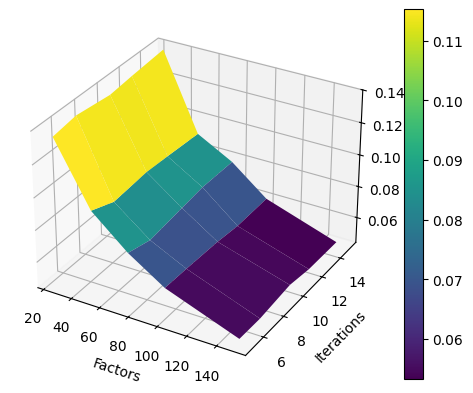

In [26]:
map_values = np.array(map_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(factors_values, iterations_values, map_values.T, cmap=cm.viridis)

ax.set_xlabel('Factors')
ax.set_ylabel('Iterations')
ax.set_zlabel('MAP@10')

fig.colorbar(surf)
plt.show()

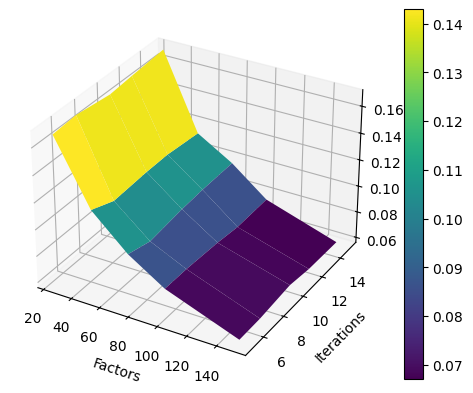

In [27]:
ndcg_values = np.array(ndcg_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(factors_values, iterations_values, ndcg_values.T, cmap=cm.viridis)

ax.set_xlabel('Factors')
ax.set_ylabel('Iterations')
ax.set_zlabel('MAP@10')

fig.colorbar(surf)
plt.show()

## Mértricas de desempeño

## Ranking con datos de testeo

In [43]:
import json

test = json.load(open(os.path.join("..", "templates", "ranking_template_fill.json")))

In [46]:
for user in test.keys():
    user_id = user_ids[int(user)]
    ranking = list(model_als.recommend(userid=user_id, user_items=user_item_matrix[user_id], N=10)[0])
    ranking = [int(itemset[r]) for r in ranking] # Convierte los items a su id original
    test[user] = ranking

In [47]:
with open(os.path.join("..", "predictions", "als_ranking.json"), "w") as file:
    json.dump(test, file, indent=4)